# Your First RNN

**Exercise objectives**:

- Better understand temporal data
- Build your first Recurrent Neural Network


<hr>
<hr>

## 1. The data

Let's start with simple sequences of observations:

In [1]:
from tensorflow import keras
import numpy as np

2022-03-06 22:01:00.327958: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-06 22:01:00.328016: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
X = np.load('X.npy')
y = np.load('y.npy')

In [3]:
print(X.shape)
print(X[0])

(25000, 10, 3)
[[  0.803     10.728925 102.      ]
 [  0.5       10.728925 102.      ]
 [  0.603     10.728925 102.      ]
 [  0.711     10.728925 130.      ]
 [  0.937     10.728925 130.      ]
 [  1.051     10.728925 130.      ]
 [  1.118     32.       108.      ]
 [  4.87      32.       108.      ]
 [  4.973     33.       108.      ]
 [  5.199     39.       108.      ]]


In [4]:
print(y.shape)
print(y[0])

(25000,)
6.499


☝️ The data describes the evolution of the **employment status of a person, year after year**: each sequence corresponds to 10 consecutive years, where each year describes a job situation, comprising of 3 components
- the salary,
- the number of persons under one's responsability,
- the size of the company. 

So, from this 25000 sequences, each of 10 consecutive observations, the goal is to predict the salary on the 11th year based on the past observations. 

❓ **Question** ❓ Take some sequences and plot the evolution of their salaries, of the persons under their responsibility and of the company sizes. You might see some correlation between the three variables.

In [5]:
import matplotlib.pyplot as plt

In [25]:
X[0,:,2]

array([102., 102., 102., 130., 130., 130., 108., 108., 108., 108.],
      dtype=float32)

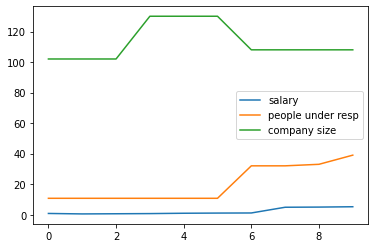

In [27]:
plt.plot(X[0,:,0], label='salary')
plt.plot(X[0,:,1], label='people under resp')
plt.plot(X[0,:,2], label='company size')
plt.legend();


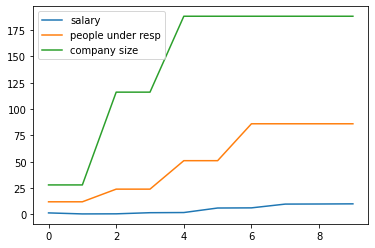

In [28]:
plt.plot(X[5,:,0], label='salary')
plt.plot(X[5,:,1], label='people under resp')
plt.plot(X[5,:,2], label='company size')
plt.legend();

❓ **Question** ❓ Plot the distribution of all the salaries, persons under one's responsibility, and company sizes to get a better understanding of the variability of observations

In [29]:
X[:,:,0]

array([[0.803, 0.5  , 0.603, ..., 4.87 , 4.973, 5.199],
       [1.53 , 1.682, 1.88 , ..., 6.433, 6.562, 6.729],
       [2.101, 2.153, 2.209, ..., 2.72 , 2.835, 2.946],
       ...,
       [1.237, 1.268, 1.258, ..., 1.873, 1.995, 2.098],
       [2.619, 1.299, 1.301, ..., 2.487, 2.617, 2.552],
       [0.8  , 3.447, 3.507, ..., 2.143, 2.272, 2.371]], dtype=float32)

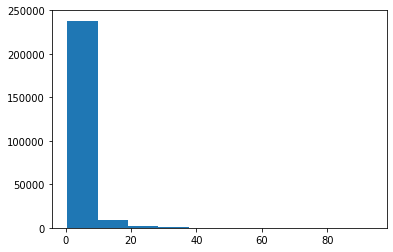

In [41]:
plt.hist(X[:,:,0].flatten());

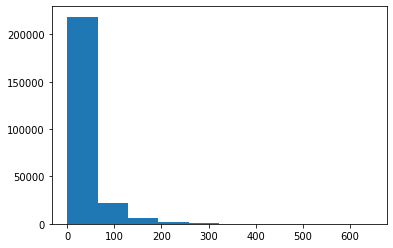

In [39]:
plt.hist(X[:,:,1].flatten());

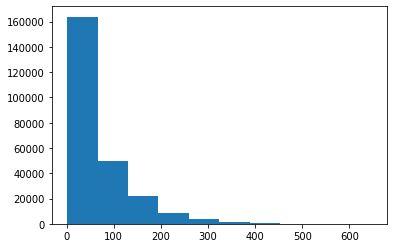

In [40]:
plt.hist(X[:,:,2].flatten());

❓ **Question** ❓  Split your dataset between a train and test set (20/80%)

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# 2. A Simple RNN

Now, you will create your first Recurrent Neural Network. Let's start simple

❓ **Question** ❓ Write a model that has: 
- a `Normalization` layer adapted on the training set
- a `SimpleRNN` layer with 20 `units` - don't forget to choose the `tanh` activation function
- a Dense layer with 10 neurons
- a last Dense layer specific to your task (predict a salary)

Remember, you don't need to specify an `input_shape`: as soon as your normalizer has been adapted to your train set, it has memorized it.

In [44]:
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Flatten

In [46]:
norm = Normalization()
norm.adapt(X_train)

In [47]:
model = Sequential()

model.add(norm)

model.add(SimpleRNN(20, activation='tanh'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='linear'))

❓ **Question** ❓ Compute the number of trainable parameters of your model using `model.summary`. 

Then, try to recompute them by hand

💡 Hints: 
- Your `normalization` layer has 7 non-trainable params, which comprise of the mean and standard deviation of each 3 features (salary, persons under responsibility, company size) plus one bias set to 0

- If $\color{green}{n_h}$ RNN units are applied in parallel to $\color{red}{n_x}$ features, the layer has $\color{green}{n_h}(\color{green}{n_h} + \color{red}{n_x} + 1)$ parameters to train. Notice how this number is *independent* of the length of each sequences (here 10 days)


In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, None, 3)          7         
 ion)                                                            
                                                                 
 simple_rnn (SimpleRNN)      (None, 20)                480       
                                                                 
 dense (Dense)               (None, 10)                210       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 708
Trainable params: 701
Non-trainable params: 7
_________________________________________________________________


In [58]:
7 + \
20 * (20 + 3 + 1) + \
10 * 20 + 10 + \
10 * 1 + 1

708

❓ **Question** ❓ Compile your model. Remember to first use the `rmsprop` optimizer (instead of Adam).

In [59]:
model.compile(loss='mse',optimizer='rmsprop', metrics=['mae'])

❓ **Question** ❓ Run your model on your data. Use a validation split of 20% and an early stopping criterion (patience=5). Evaluate your performance on the test set

In [60]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=5, restore_best_weights=True)

model.fit(X_train, y_train,
          epochs=100, 
          batch_size=32, 
          validation_split=0.2,
          callbacks=[es])

Epoch 1/100
500/500 [==============================] - 5s 8ms/step - loss: 21.9805 - mae: 1.9700 - val_loss: 5.6915 - val_mae: 0.7198
Epoch 2/100
500/500 [==============================] - 3s 7ms/step - loss: 3.5557 - mae: 0.5477 - val_loss: 2.0021 - val_mae: 0.4316
Epoch 3/100
500/500 [==============================] - 3s 7ms/step - loss: 1.7967 - mae: 0.4146 - val_loss: 1.3450 - val_mae: 0.4678
Epoch 4/100
500/500 [==============================] - 4s 7ms/step - loss: 1.3079 - mae: 0.3762 - val_loss: 1.0400 - val_mae: 0.3691
Epoch 5/100
500/500 [==============================] - 4s 7ms/step - loss: 1.0917 - mae: 0.3599 - val_loss: 0.9240 - val_mae: 0.3292
Epoch 6/100
500/500 [==============================] - 4s 7ms/step - loss: 0.9646 - mae: 0.3518 - val_loss: 1.1393 - val_mae: 0.6347
Epoch 7/100
500/500 [==============================] - 4s 8ms/step - loss: 0.8965 - mae: 0.3511 - val_loss: 0.8360 - val_mae: 0.3620
Epoch 8/100
500/500 [==============================] - 4s 7ms/step -

In [61]:
model.evaluate(X_test,y_test)

157/157 [==============================] - 1s 5ms/step - loss: 0.4693 - mae: 0.2724


[0.469332218170166, 0.2723940312862396]

# Baseline comparison?


In the case of a usual regression model, a baseline prediction for `y_test` could be to predict the average of `y_train`.

With temporal data, it often happens that you try to predict a value that you have already seen in the past: here, the salary. In that case, a baseline model could be to predict for instance that the 11-th salary is equal to the 10-th salary.

❓ **Question** ❓ Compute the Mean Absolute Error of a model that would predict that the salary remains constant between the 10-th and 11-th year and compare it to your RNN.

In [62]:
pred = X[:,-1,0]

In [63]:
from sklearn.metrics import mean_absolute_error

In [64]:
mean_absolute_error(y, pred)

0.5951943998979569

You have probably seen that your prediction is a little bit better than the baseline model

# LSTM

❓ **Question** ❓ Write the exact same model, but with a `LSTM` instead of a `SimpleRNN` and evaluate your performance on the test set

In [65]:
from tensorflow.keras.layers import LSTM

In [ ]:
model_lstm = Sequential()

model_lstm.add(norm)
model_lstm.add(LSTM(20, activation='tanh'))
model_lstm.add(Dense(10, activation='relu'))
model_lstm.add(Dense(1, activation='linear'))

model_lstm.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])

model_lstm.fit(X_train,y_train, epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30
500/500 [==============================] - 8s 12ms/step - loss: 32.2612 - mae: 2.8554 - val_loss: 11.0563 - val_mae: 1.2516
Epoch 2/30
500/500 [==============================] - 5s 10ms/step - loss: 5.9532 - mae: 0.7997 - val_loss: 2.6804 - val_mae: 0.5669
Epoch 3/30
500/500 [==============================] - 5s 10ms/step - loss: 2.1041 - mae: 0.4242 - val_loss: 1.4289 - val_mae: 0.3649
Epoch 4/30
500/500 [==============================] - 5s 10ms/step - loss: 1.3308 - mae: 0.3653 - val_loss: 1.0589 - val_mae: 0.3386
Epoch 5/30
500/500 [==============================] - 5s 9ms/step - loss: 1.0811 - mae: 0.3442 - val_loss: 0.9391 - val_mae: 0.3610
Epoch 6/30
500/500 [==============================] - 5s 9ms/step - loss: 0.9457 - mae: 0.3337 - val_loss: 0.8058 - val_mae: 0.2774
Epoch 7/30
500/500 [==============================] - 5s 10ms/step - loss: 0.8601 - mae: 0.3273 - val_loss: 0.8100 - val_mae: 0.3391
Epoch 8/30
500/500 [==============================] - 5s 10ms/step - 

In [ ]:
model_lstm.evaluate(X_test, y_test)

## 🏁 Congratulation

You now know how to run RNN on sequence data!

Note: The sequences you worked with are totally fake. In case you need to train and reproduce similar data, you can find bellow the functions that have been used to simulate this data.

# Utils (for reference only)

In [ ]:
def create_sequences(number):
    X, y = [], []
    
    for i in range(number):
        x_i, y_i = create_individual_sequence(10)
        X.append(x_i)
        y.append(y_i)
        
    return np.array(X), np.array(y)
            
def create_individual_sequence(length):
    company_sizes = []
    nb_persons = []
    salaries = []
    
    
    # Education level
    educ_level = [max(0, int(np.random.normal(10, 2)))]*length
    
    # Company size
    current_size = int(1 + np.random.beta(.4, 4)*500)
    for i in range(length):
        if not np.random.randint(4): # Change 1 out of 3 possibilities 
            current_size = int(max(1, np.random.normal(current_size, 50)))
        company_sizes.append(current_size)
    
    # Number of persons
    nb_iter = np.random.beta(.15, 4)*300
    for i in range(length):
        if not np.random.randint(2): # Change 1 out of 2 possibilities
            R_1 = np.random.beta(0.5, 8)*3
            nb_iter = nb_iter + max(-2, R_1*company_sizes[i] + np.random.randint(-2, 2))
            nb_iter = max(0, nb_iter)
            nb_iter = int(min(company_sizes[i]-1, nb_iter))
        nb_persons.append(nb_iter)
        
    
    # Salary
    salary_iter = max(800, int(np.random.normal(1200, 300)+ 0.05*company_sizes[0] +  np.random.normal(40, 400)))
    salaries.append(salary_iter)
    for i in range(1, length + 1):
        R_1 = np.random.normal(100, 50)
        change_person = nb_persons[i-1] - nb_persons[i-2]
        change_company = max(0, company_sizes[i-1] - company_sizes[i-2])
        salary_iter = salary_iter + 0.05*change_company + change_person*R_1 + np.random.normal(100, 50)
        salary_iter = max(int(salary_iter), 500)
        
        salaries.append(salary_iter)

    y = salaries[-1]/1000
    salaries = [_/1000 for _ in salaries[:-1]]
    
    return np.array([salaries, nb_persons, company_sizes]).T, y

In [ ]:
#X, y = create_sequences(25000)

#np.save('X', X.astype(np.float32))
#np.save('y', y)